#### Imagenet Attack Notebook

In [1]:
%%capture installation
import os
import pickle
import argparse
import datetime

import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder, CIFAR10VAE,
                                CIFAR10LightningAutoencoder, CIFAR10NoisyLightningAutoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS, FastGradientMethod
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

2023-04-01 12:29:51.657340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 12:29:51.865264: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-01 12:29:51.901773: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-01 12:29:53.141158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [7]:
class Args:
    batch_size = 64
    dataset_len = 1000
    attack_name = "fgsm"
    device  = "cuda"
    model_name = "imagenet_inceptionv3"
    ae_name = "vgg_16"
    plot = False
    plot_dir = "./plots"
    # kwargs = {}
    kwargs = {"eps": 0.001, "batch_size": 64} # fgsm
    # kwargs = {"batch_size": 128, "nb_grads": 5, "epsilon": 1e-04} # deepfool
    # kwargs = {"eps": 0.003, "batch_size": 64} # pgd and bim
    # kwargs = {"batch_size": 32, "theta": 0.3} # jsma
    # kwargs = {"batch_size": 64} # cnw
    # kwargs = {"batch_size": 128, "targeted": False} # boundary and elastic and signopt

args = Args()

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [8]:
%%capture installation
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")

train_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader!!!!!")

In [9]:
result = {attack_name.__name__: {}}
xs, ys = [], []
cas, ras = [], []
x_adv, x_adv_acc, delta_x = [], [], []
modf_x_adv, modf_x_adv_acc = [], []
z_adv, x_hat_adv, x_hat_adv_acc, delta_x_hat = [], [], [], []
orig_time, modf_time = [], []

from tqdm import tqdm

for images, labels in tqdm(train_dataloader):
    x_test, y_test = images.to(args.device), labels.to(args.device)
    x_test_np, y_test_np = x_test.cpu().numpy(), y_test.cpu().numpy()

    with torch.no_grad():
        z_test = autoencoder_model.get_z(x_test)
    z_test_np = z_test.detach().cpu().numpy()

    x, y, z = (x_test, x_test_np), (y_test, y_test_np), (z_test, z_test_np)

    config["latent_shape"] = (512, 7, 7)
    classifier, hybrid_classifier, ca, ra = hybridize(x, y, z, 
                                                        config, classifier_model, autoencoder_model)
    xs.append(x[0])
    for ele in y[1]:
        ys.append(ele)
    cas.append(ca)
    ras.append(ra)
    # Perform attack
    conditionals = {
        "calculate_original": True,
        "is_class_constrained": False
    }
    results: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model, args.kwargs, conditionals)[attack_name.__name__]
    # results = result[attack_name.__name__]
    x_adv.append(results["x_adv"])
    x_adv_acc.append(results["x_adv_acc"])
    delta_x.append(results["delta_x"])
    modf_x_adv.append(results["modf_x_adv"])
    modf_x_adv_acc.append(results["modf_x_adv_acc"])
    z_adv.append(results["z_adv"])
    x_hat_adv.append(results["x_hat_adv"])
    x_hat_adv_acc.append(results["x_hat_adv_acc"])
    delta_x_hat.append(results["delta_x_hat"])

    orig_time.append(results["orig_time"])
    modf_time.append(results["modf_time"])

print("Accuracy on benign test examples: {}%".format((sum(cas)/len(cas)) * 100))
print("Accuracy on benign test examples(from reconstructed): {}%".format((sum(ras)/len(ras)) * 100))

result[attack_name.__name__]["x_adv"] = np.vstack(x_adv)
result[attack_name.__name__]["x_adv_acc"] = sum(x_adv_acc) / len(x_adv_acc)
result[attack_name.__name__]["delta_x"] = np.vstack(delta_x)

result[attack_name.__name__]["modf_x_adv"] = np.vstack(modf_x_adv)
result[attack_name.__name__]["modf_x_adv_acc"] = sum(modf_x_adv_acc) / len(modf_x_adv_acc)
result[attack_name.__name__]["z_adv"] = np.vstack(z_adv)
result[attack_name.__name__]["x_hat_adv"] = np.vstack(x_hat_adv)
result[attack_name.__name__]["x_hat_adv_acc"] = sum(x_hat_adv_acc) / len(x_hat_adv_acc)
result[attack_name.__name__]["delta_x_hat"] = np.vstack(delta_x_hat)
xs = torch.vstack(xs)
ys = np.array(ys)

print("Robust accuracy of original adversarial attack: {}%".format(result[attack_name.__name__]["x_adv_acc"] * 100))
print("Robust accuracy of modified adversarial attack: {}%".format(result[attack_name.__name__]["modf_x_adv_acc"] * 100))
print("Robust accuracy of reconstructed adversarial attack: {}%".format(result[attack_name.__name__]["x_hat_adv_acc"] * 100))

print(f"Time taken for original attack: {sum(orig_time)} seconds")
print(f"Time taken for modified attack: {sum(modf_time)} seconds")

100%|██████████| 16/16 [00:59<00:00,  3.74s/it]


Accuracy on benign test examples: 66.73828125%
Accuracy on benign test examples(from reconstructed): 43.22265625%
Robust accuracy of original adversarial attack: 49.74609375%
Robust accuracy of modified adversarial attack: 56.11328125%
Robust accuracy of reconstructed adversarial attack: 15.625%
Time taken for original attack: 10.55856728553772 seconds
Time taken for modified attack: 10.80263090133667 seconds


In [10]:
if conditionals["calculate_original"]:
    x_adv = result[attack_name.__name__]["x_adv"]
    delta_x = result[attack_name.__name__]["delta_x"]

x_hat_adv  = result[attack_name.__name__]["x_hat_adv"]
modf_x_adv = result[attack_name.__name__]["modf_x_adv"]

# noises
delta_x_hat = result[attack_name.__name__]["delta_x_hat"]

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def plot_batch(images):
    plt.figure(figsize=(20, 12))
    images = torch.Tensor(images).reshape(-1, 3, 224, 224)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=False, range=(0,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

start = 0
end   = 1

# x_hat_adv = x_hat_adv * 255
# import torchvision.transforms as transforms
# x_hat_adv_tensor = torch.tensor((x_hat_adv * 255)).to(device)
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# x_hat_adv = normalize(x_hat_adv_tensor).cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


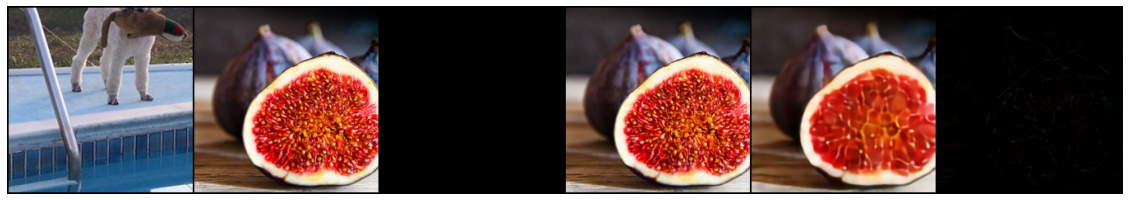

: 

In [12]:
images = np.vstack([x[1][start: end], x_adv[start: end], delta_x[start: end], modf_x_adv[start: end], x_hat_adv[start: end], delta_x_hat[start: end]])
plot_batch(images)

#### LPIPS Similarity Score

In [66]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img_orig = torch.Tensor(x_adv) # image should be RGB, IMPORTANT: normalized to [-1,1]
img_modf = torch.Tensor(x_hat_adv)
# img_modf = torch.Tensor(modf_x_adv)
img = xs.detach().cpu()

orig_lpips = loss_fn_alex(img, img_orig)
modf_lpips = loss_fn_alex(img, img_modf)
print("Average LPIPS score of original adversarial attack: ", orig_lpips.flatten().mean())
print("Average LPIPS score of modifed adversarial attack: ", modf_lpips.flatten().mean())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Average LPIPS score of original adversarial attack:  tensor(0.0010, grad_fn=<MeanBackward0>)
Average LPIPS score of modifed adversarial attack:  tensor(0.2654, grad_fn=<MeanBackward0>)


In [57]:
## Harmonic Means
orig_acc = result[attack_name.__name__]["x_adv_acc"]
modf_acc = result[attack_name.__name__]["x_hat_adv_acc"]

orig_lpips_avg = orig_lpips.flatten().mean()
modf_lpips_avg = modf_lpips.flatten().mean()

orig_hm = (orig_acc * orig_lpips_avg) / (orig_acc + orig_lpips_avg)
modf_hm = (modf_acc * modf_lpips_avg) / (modf_acc + modf_lpips_avg)

print(f"Original HM: {orig_hm}, Modified HM: {modf_hm}")

Original HM: 0.014180284924805164, Modified HM: 0.000975154631305486


#### Calculating L2 and Linf Norm

In [68]:
orig_linf = torch.max(torch.abs(xs - img_orig.to(device)))
modf_linf = torch.max(torch.abs(xs - img_modf.to(device)))

print("Average Linf distance between original and original adversarial images: ", orig_linf.mean())
print("Average Linf distance between original and modified adversarial images: ", modf_linf.mean())

Average Linf distance between original and original adversarial images:  tensor(0.0030, device='cuda:0')
Average Linf distance between original and modified adversarial images:  tensor(0.9216, device='cuda:0')


In [30]:
orig_l2 = torch.cdist(xs, img_orig.to(device), p=2)
modf_l2 = torch.cdist(xs, img_modf.to(device), p=2)
print("Average L2 distance between original and original adversarial images: ", orig_l2.mean())
print("Average L2 distance between original and modified adversarial images: ", modf_l2.mean())

Average L2 distance between original and original adversarial images:  tensor(3.9226, device='cuda:0')
Average L2 distance between original and modified adversarial images:  tensor(3.8935, device='cuda:0')


In [67]:
# save adversarial images
fileObj = open(f"./objects/{dataset_name}_{args.attack_name}.pkl", 'wb')
pickle.dump(result, fileObj)
fileObj.close()

In [ ]:
if conditionals["calculate_original"]:
    plot_images(x_adv[start: end])

In [ ]:
if conditionals["calculate_original"]:
    plot_images(delta_x[start: end])

In [ ]:
plot_images(x[1][start: end])

In [ ]:
plot_images(modf_x_adv[start: end])

In [ ]:
plot_images(delta_x_hat[start: end])

In [ ]:
plot_images(x_hat_adv[start: end])

#### Robust Bench Benchmarks

In [17]:
from robustbench.utils import load_model

models = ["Rebuffi2021Fixing_70_16_cutmix_extra", "Gowal2021Improving_70_16_ddpm_100m",
          "Rebuffi2021Fixing_70_16_cutmix_ddpm", "Sehwag2021Proxy_ResNest152"]
# model = load_model(model_name='Carmon2019Unlabeled', model_dir="/home/harsh/scratch/models/", dataset='cifar10', threat_model='Linf')
# model = load_model(model_name='Engstrom2019Robustness', dataset='cifar10', threat_model='Linf')
# model = load_model(model_name='Rice2020Overfitting', dataset='cifar10', threat_model='Linf')

In [ ]:
for model in models[4:]:
    model = load_model(
        model_name=model,
        dataset="cifar10",
        model_dir="/home/harsh/scratch/models/",
        threat_model="Linf"
    )
    criterion = nn.CrossEntropyLoss()
    classifier = PyTorchClassifier( 
        model=model,
        clip_values=(0, 1),
        loss=criterion,
        # optimizer=optimizer,
        input_shape=(32, 32),
        nb_classes=10,
    )

    orig_preds = classifier.predict(x_adv)
    modf_preds = classifier.predict(x_hat_adv)
    orig_acc = np.sum(np.argmax(orig_preds, axis=-1) == ys) / len(ys)
    modf_acc = np.sum(np.argmax(modf_preds, axis=-1) == ys) / len(ys)
    print("Robust original accuracy: ", orig_acc)
    print("Robust modified accuracy: ", modf_acc)

#### Finding Border

In [25]:
Rebuffi2021Fixing_70_16_cutmix_extra
Robust original accuracy:  0.7734375
Robust modified accuracy:  0.609375
Gowal2021Improving_70_16_ddpm_100m
Robust original accuracy:  0.765625
Robust modified accuracy:  0.5390625
Rebuffi2021Fixing_70_16_cutmix_ddpm
Download started: path=/home/harsh/scratch/models/cifar10/Linf/Rebuffi2021Fixing_70_16_cutmix_ddpm.pt (gdrive_id=1-8CWRT-OFWyrz4T4s0I2mbFjPg8K_MUi)
Download finished: path=/home/harsh/scratch/models/cifar10/Linf/Rebuffi2021Fixing_70_16_cutmix_ddpm.pt (gdrive_id=1-8CWRT-OFWyrz4T4s0I2mbFjPg8K_MUi)
Robust original accuracy:  0.7109375
Robust modified accuracy:  0.5703125
Sehwag2021Proxy_ResNest152
Download started: path=/home/harsh/scratch/models/cifar10/Linf/Sehwag2021Proxy_ResNest152.pt (gdrive_id=1XSjtJZAvDlua6wTM6WRLvW_jON-DqLgT)
Download finished: path=/home/harsh/scratch/models/cifar10/Linf/Sehwag2021Proxy_ResNest152.pt (gdrive_id=1XSjtJZAvDlua6wTM6WRLvW_jON-DqLgT)
Robust original accuracy:  0.734375
Robust modified accuracy:  0.0859375

(7, 128)

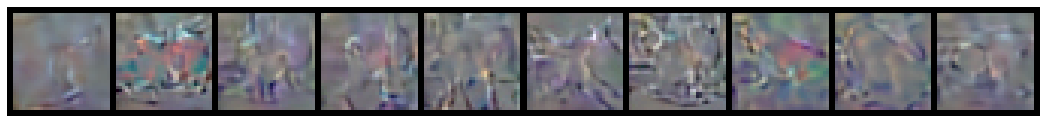

In [82]:
z = autoencoder_model.get_z(x[0][start: end])
noisy_z = z + 0.0001
x_hat = autoencoder_model.get_x_hat(z)
noisy_x_hat = autoencoder_model.get_x_hat(noisy_z)
delta = noisy_x_hat - x_hat
plot_images(delta.cpu().detach())

In [ ]:
Deep learning models have achieved remarkable success in various applications such as computer vision, natural language processing, and speech recognition. However, it has been shown that these models are vulnerable to adversarial attacks, where an attacker deliberately manipulates input data to cause a misclassification or error in the model's output. Adversarial attacks pose a significant threat to the security and reliability of deep learning models, especially in critical applications such as autonomous driving and healthcare.

One of the primary challenges in achieving adversarial robustness is the lack of an exact mathematical definition of semantic correctness. Adversarial attacks that remain undetected by human eyes are crucial in defining semantic correctness. Most current attack and defense strategies utilize bounded threat models such as $L_{2}$ or $L_{inf}$ distance, spatial perturbations, etc., which generate adversarial examples that lack perceptual and semantic closeness to the original images.

Related Work:

Several approaches have been proposed to address adversarial attacks, including adversarial training, defensive distillation, input preprocessing, and feature squeezing. Adversarial training is a commonly used method to improve the robustness of deep learning models. The method involves training the model on both clean and adversarial examples generated using a specific attack algorithm. Defensive distillation is another approach that involves training the model on the soft outputs (probabilities) instead of the hard outputs (class labels). Input preprocessing and feature squeezing are methods that modify the input data to make the model more robust to adversarial attacks.

Despite the success of these methods, they often fail to provide a robust defense against sophisticated attacks that consider semantic and perceptual similarity between the adversarial and original images. Several recent works have proposed methods that consider semantic similarity to generate adversarial examples that are perceptually indistinguishable from the original images. However, these methods are often computationally expensive or require access to additional information such as segmentation masks.